<a href="https://colab.research.google.com/github/zhj396/artificial_intelligence/blob/main/vanilla_gan/vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 导入第三方库
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

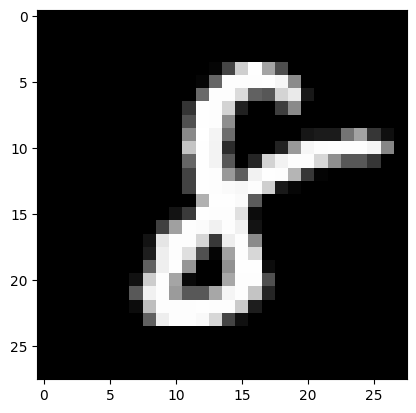

In [5]:
# 加载MNIST数据集
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 显示第500个训练图像
img = train_images[499]  # Python是0-based索引
plt.imshow(img, cmap='Greys_r')
plt.show()

train_images = (train_images.astype(np.float32) - 127.5) / 127.5  # 归一化到 [-1, 1]
train_images = train_images.reshape(-1, 784)  # 展平 (60000, 784)

In [6]:
# 生成器（Generator）
from tensorflow.keras import layers, Model

def build_generator(noise_dim, units=128, out_dim=784):
    model = tf.keras.Sequential([
        layers.Dense(units, input_dim=noise_dim),  # 全连接层
        layers.LeakyReLU(alpha=0.01),              # LeakyReLU 激活
        layers.Dropout(0.2),                       # Dropout
        layers.Dense(out_dim, activation='tanh'),  # 输出层，tanh 激活（-1 到 1）
    ])
    return model

In [7]:
# 判别器（Discriminator）
def build_discriminator(img_dim=784, units=128):
    model = tf.keras.Sequential([
        layers.Dense(units, input_dim=img_dim),    # 全连接层
        layers.LeakyReLU(alpha=0.01),              # LeakyReLU 激活
        layers.Dense(1, activation='sigmoid'),     # 输出层，sigmoid 激活（0 到 1）
    ])
    return model

In [8]:
# 定义 GAN
noise_dim = 100
generator = build_generator(noise_dim)
discriminator = build_discriminator()

# 定义优化器
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

# 定义损失函数
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# 训练步骤
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, noise_dim])  # 生成噪声

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 生成假图片
        fake_images = generator(noise, training=True)

        # 判别器判断真假
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        # 计算损失
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)  # 生成器希望判别器认为假图片是真的
        disc_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        disc_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake  # 判别器总损失

    # 计算梯度并更新
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [9]:
# 训练循环
epochs = 100
batch_size = 64

for epoch in range(epochs):
    for i in range(len(train_images) // batch_size):
        batch = train_images[i * batch_size : (i + 1) * batch_size]
        gen_loss, disc_loss = train_step(batch)

    # 每 10 个 epoch 打印一次
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

Epoch 0, Gen Loss: 1.054263949394226, Disc Loss: 0.963017463684082
Epoch 10, Gen Loss: 1.7545113563537598, Disc Loss: 0.9182289838790894
Epoch 20, Gen Loss: 2.372159004211426, Disc Loss: 0.9838029742240906
Epoch 30, Gen Loss: 1.5550413131713867, Disc Loss: 0.8574496507644653
Epoch 40, Gen Loss: 1.7868788242340088, Disc Loss: 0.9098373651504517
Epoch 50, Gen Loss: 1.9440635442733765, Disc Loss: 0.9921630620956421
Epoch 60, Gen Loss: 2.118140935897827, Disc Loss: 1.0150541067123413
Epoch 70, Gen Loss: 1.6979858875274658, Disc Loss: 0.9104926586151123
Epoch 80, Gen Loss: 1.6248338222503662, Disc Loss: 0.907141387462616
Epoch 90, Gen Loss: 1.7359466552734375, Disc Loss: 0.7817238569259644


In [10]:
# 保存为 HDF5
generator.save('generator.h5')
discriminator.save('discriminator.h5')

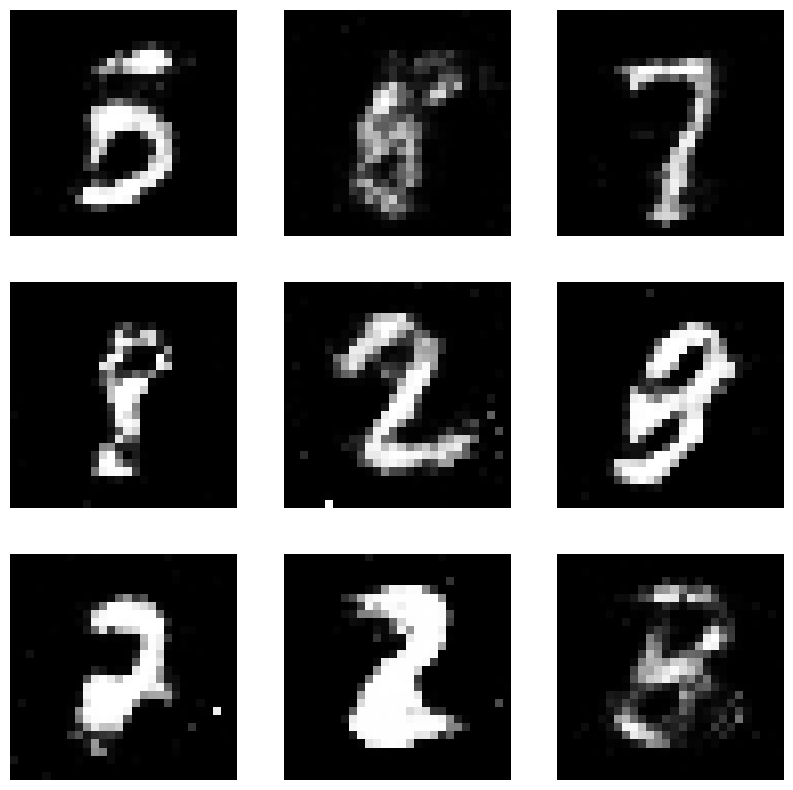

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载生成器
# 从 HDF5 加载
generator = tf.keras.models.load_model('generator.h5')
discriminator = tf.keras.models.load_model('discriminator.h5')

# 2. 生成随机噪声
noise_dim = 100
num_samples = 9
noise = tf.random.normal([num_samples, noise_dim])

# 3. 生成图像
generated_images = generator(noise, training=False).numpy()  # 转换为 NumPy 数组

# 4. 调整形状
if len(generated_images.shape) == 2:  # 形状为 (batch_size, 784)
    generated_images = generated_images.reshape(-1, 28, 28)
elif len(generated_images.shape) == 4:  # 形状为 (batch_size, 28, 28, 1)
    generated_images = generated_images.squeeze()  # 去除通道维度

# 5. 归一化到 [0, 255] 并转换为 uint8
generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)

# 6. 显示图像
plt.figure(figsize=(10, 10))
num_samples = min(num_samples, generated_images.shape[0])  # 防止索引越界
for i in range(num_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
# 保存生成的图片
from PIL import Image

for i in range(num_samples):
    img = Image.fromarray(generated_images[i])
    img.save(f'generated_image_{i}.png')